In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import keras.callbacks as callbacks
import keras.utils.np_utils as kutils
from keras.preprocessing.image import ImageDataGenerator

from load_cifar10 import load_cifar10_data
from densenet169 import *

Using TensorFlow backend.


>### CIFAR10 with Imagenet pretrained Densenet 169: 
* Resize original CIFAR10 images to 224x224
* Load Imagenet pretrained densenet_169 and tune it's weights
* Save best model checkpoint based on validation accuracy

In [ ]:
WORKDIR = '../data/finetune_densenet_169/prod/'
TEST_PATH = '../data/test.npy'  

IMG_ROWS, IMG_COLS = 224, 224
NUM_CLASSES = 10 
BATCH_SIZE = 24 
LEARNING_RATE = 1e-3
LR_DROP = 10

AUGMENTATIONS = {
    'rotation_range': 10,
    'width_shift_range': 5./32,
    'height_shift_range': 5./32,
    'horizontal_flip': True,
}

In [ ]:
DEV_MODE = False

if DEV_MODE:
    NB_EPOCH = 3
    NUM_OBS_TRAIN = 500
    NUM_OBS_VALID = 500
    X_train, Y_train, X_valid, Y_valid = \
        load_cifar10_data(img_rows=IMG_ROWS, 
                          img_cols=IMG_COLS, 
                          num_obs_train=NUM_OBS_TRAIN, 
                          num_obs_valid=NUM_OBS_VALID)
else:
    NB_EPOCH = 69
    X_train, Y_train, X_valid, Y_valid, test = \
        load_cifar10_data(img_rows=IMG_ROWS, 
                          img_cols=IMG_COLS,
                          test_path=TEST_PATH)

>### Load densenet and pretrained weights
See densenet169.py for details on downloading weights.

In [ ]:
model = densenet169_model(img_rows=IMG_ROWS, img_cols=IMG_COLS, num_classes=NUM_CLASSES)
generator = ImageDataGenerator(**AUGMENTATIONS)
generator.fit(X_train, seed=0, augment=True)

def lr_scheduler(epoch): 
    return LEARNING_RATE * (0.5 ** (epoch // LR_DROP))
reduce_lr = callbacks.LearningRateScheduler(lr_scheduler)
checkpoint = callbacks.ModelCheckpoint(WORKDIR+'checkpoint.best.h5py', monitor='val_acc', 
                                       verbose=1, save_best_only=True, mode='max')

model.fit_generator(generator.flow(X_train, Y_train, batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(X_train) // BATCH_SIZE + 1, 
                    nb_epoch=NB_EPOCH,
                    callbacks=[reduce_lr, checkpoint],
                    validation_data=(X_valid, Y_valid),
                    validation_steps=X_valid.shape[0] // BATCH_SIZE, 
                    verbose=1)

In [4]:
## Check accuracy on val
model = densenet169_model(img_rows=IMG_ROWS, img_cols=IMG_COLS, num_classes=NUM_CLASSES)
model.load_weights(WORKDIR+'checkpoint.best.h5py')

predictions_valid = model.predict(X_valid, batch_size=BATCH_SIZE, verbose=1)
predictions_valid = kutils.to_categorical(np.argmax(predictions_valid, axis=1))
score = metrics.accuracy_score(Y_valid, predictions_valid)
score

10000/10000 [==============================] - 54s 5ms/step


0.9782

In [6]:
## Save prediction for 2k images test set
submission_name = 'dense169'
submission_raw = model.predict(test, batch_size=BATCH_SIZE, verbose=1)
submission = np.argmax(submission_raw, axis=1)

submission_df = pd.DataFrame(np.vstack([range(len(test)), submission]).T, columns=['Id', 'Category'])
submission_df.to_csv('../submissions/{}.csv'.format(submission_name), index=False)

2000/2000 [==============================] - 10s 5ms/step


>### Conclusions
As it turns out, tuning weights of a pretrained model is one of the best ways to obtain accurate model within a shorter period of time.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
resnet34 = pd.read_csv('../data/resnet34/prod/resnet34.csv')
wrn2810 = pd.read_csv('../data/wrn2810/prod/wrn2810.csv')
wrn168 = pd.read_csv('../data/wrn168/prod/wrn168.csv')
dense169 = pd.read_csv('../data/finetune_densenet_169/prod/dense169.csv')

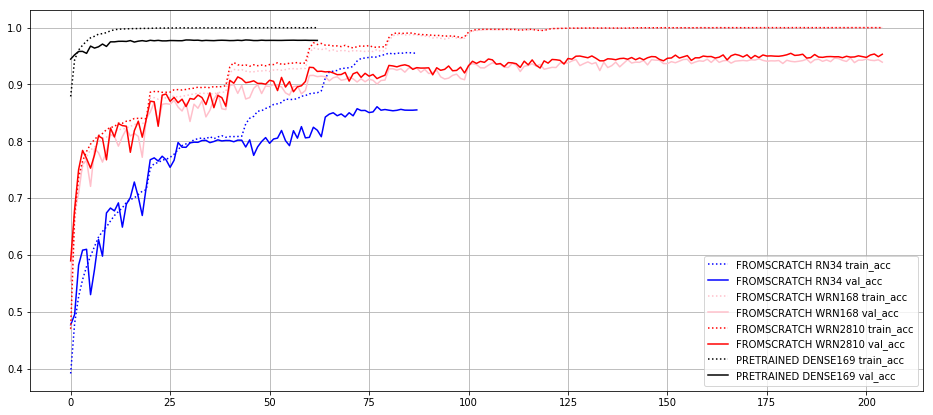

In [14]:
plt.figure(figsize=(16,7))

_=plt.plot(resnet34.acc, linestyle=':', label='FROMSCRATCH RN34 train_acc', color='b')
_=plt.plot(resnet34.val_acc, label='FROMSCRATCH RN34 val_acc', color='b')

_=plt.plot(wrn168.acc, linestyle=':', label='FROMSCRATCH WRN168 train_acc', color='pink')
_=plt.plot(wrn168.val_acc, label='FROMSCRATCH WRN168 val_acc', color='pink')

_=plt.plot(wrn2810.acc, linestyle=':', label='FROMSCRATCH WRN2810 train_acc', color='r')
_=plt.plot(wrn2810.val_acc, label='FROMSCRATCH WRN2810 val_acc', color='r')

_=plt.plot(dense169.acc, linestyle=':', label='PRETRAINED DENSE169 train_acc', color='black')
_=plt.plot(dense169.val_acc, label='PRETRAINED DENSE169 val_acc', color='black')

plt.legend()
plt.grid()